In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams["font.family"] = "FreeSans"

In [2]:
from conformal_region_designer.case_studies.car_experiments import CarEnvironment, generate_calibration_dataset, generate_train_dataset, TrajectoryPredictor
from conformal_region_designer.utils import set_square_aspect_ratio, shuffle_split_testing

In [3]:
train_X, train_Y = generate_train_dataset(100)
env_X, env_Y = generate_calibration_dataset(10_000)

In [4]:
predictor = TrajectoryPredictor(0.1)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Text(0.5, 0.98, 'Training Trajectories')

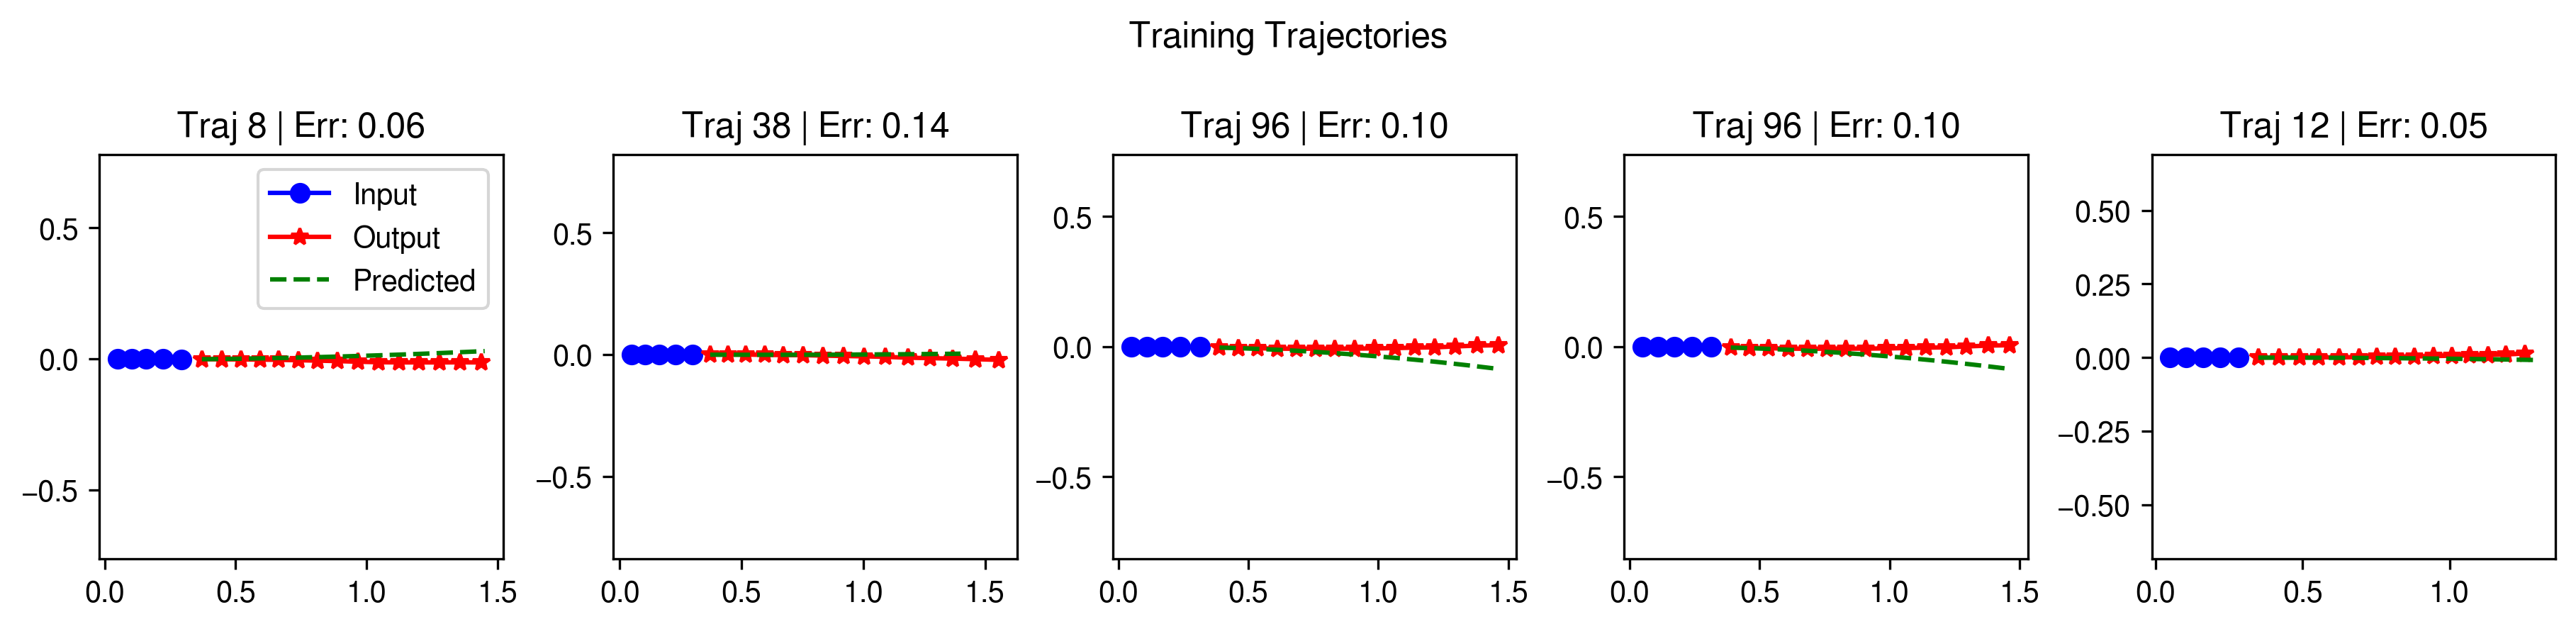

In [5]:
INDEX = np.random.choice(train_X.shape[0], 5)
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    ax.plot(train_X[INDEX[i], :, 0], train_X[INDEX[i], :, 1], 'bo-', label='Input')
    ax.plot(train_Y[INDEX[i], :, 0], train_Y[INDEX[i], :, 1], 'r*-', label='Output')
    prediction = predictor.predict_trajectory(train_X[INDEX[i]])
    error = np.linalg.norm(prediction - train_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--', label='Predicted')
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
plt.suptitle('Training Trajectories')

Text(0.5, 0.98, 'Calibration Distribution')

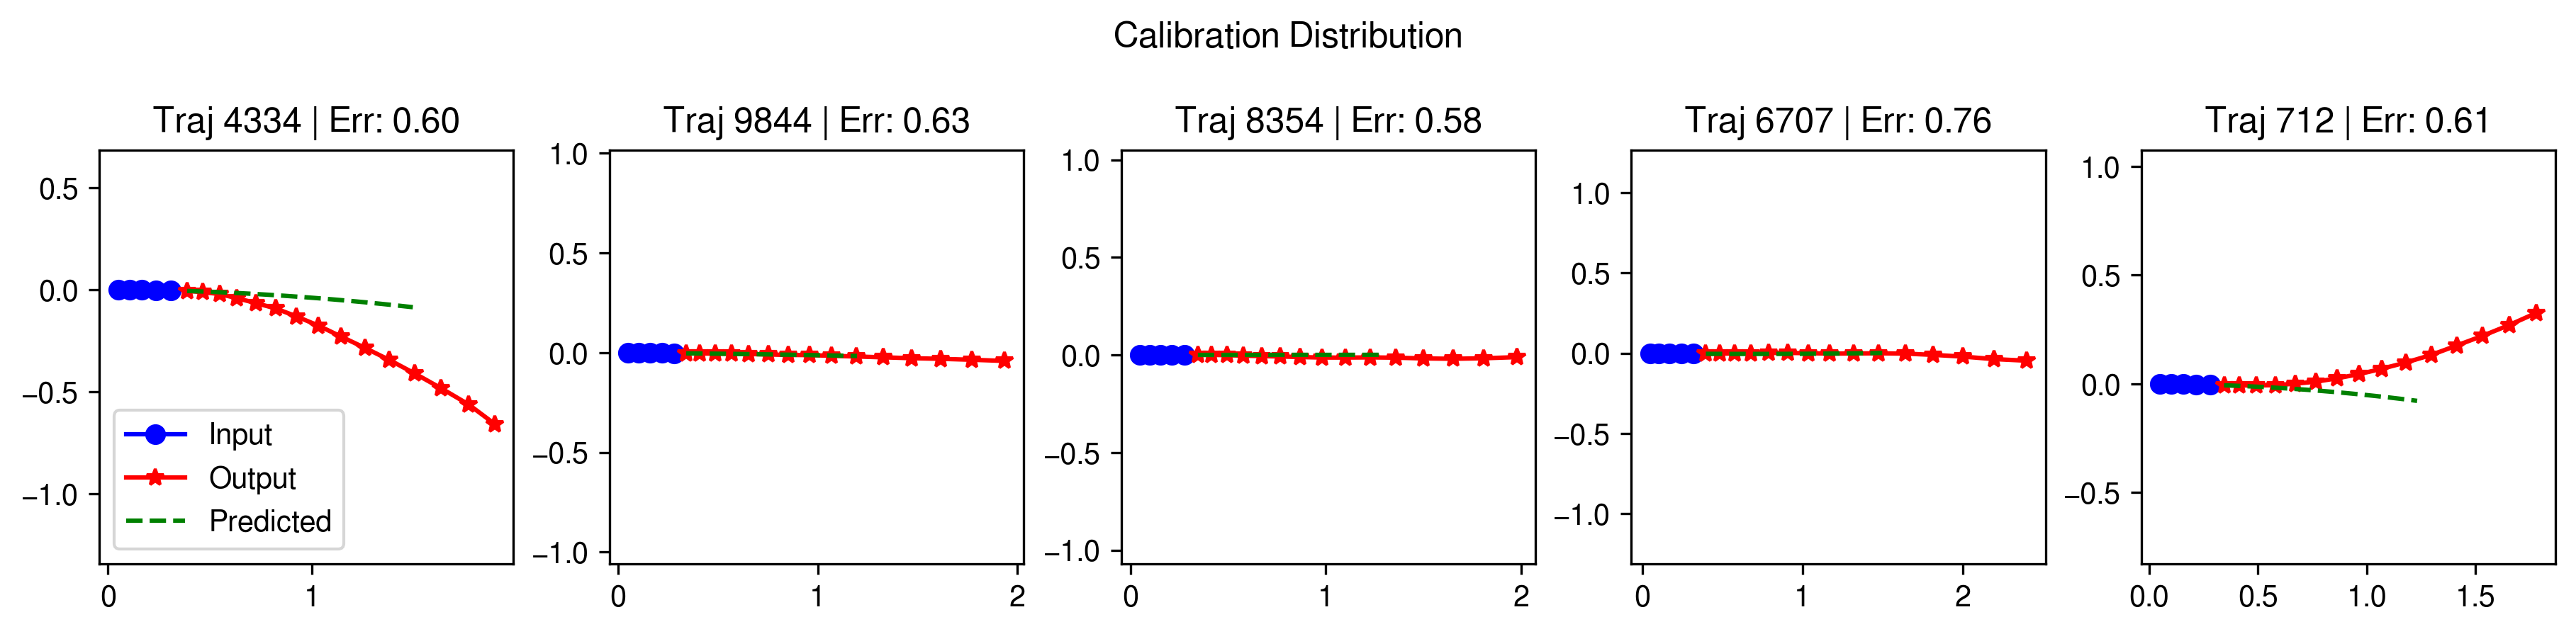

In [6]:
INDEX = np.random.choice(env_X.shape[0], 5)
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    ax.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'bo-', label='Input')
    ax.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r*-', label='Output')
    prediction = predictor.predict_trajectory(env_X[INDEX[i]])
    error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--', label='Predicted')
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
fig.suptitle('Calibration Distribution')

In [7]:
env_Y_hat = predictor.predict_batched_trajectories(env_X)
Z_env = env_Y[:,-1,:2] - env_Y_hat[:,-1,:2]
np.random.shuffle(Z_env)

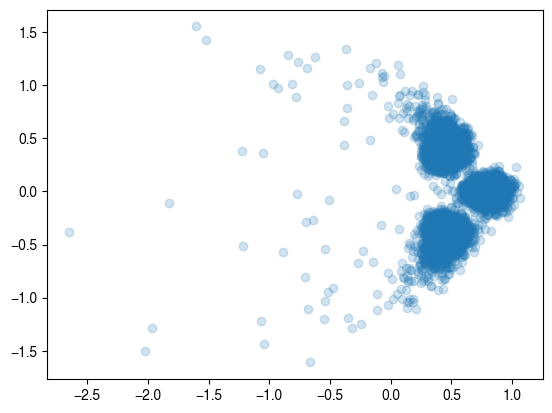

In [8]:
plt.scatter(Z_env[:,0], Z_env[:,1], alpha=0.2)

# Use Parametrized Conformal Regions for Prediction

In [9]:
from conformal_region_designer.density_estimation import KDE
from conformal_region_designer.clustering import MeanShiftClustering
from conformal_region_designer.shapes import HyperRectangle, ConvexHullTemplate, Ellipse
from conformal_region_designer.conformity_optimizer import ConformalRegion

In [10]:
Z_cal_one = Z_env[:Z_env.shape[0]//3]
Z_cal_two = Z_env[Z_env.shape[0]//3:2*(Z_env.shape[0]//3)]
Z_test = Z_env[2*(Z_env.shape[0]//3):]
Z_eval = Z_env[(Z_env.shape[0]//3):]
print(Z_cal_one.shape, Z_cal_two.shape, Z_test.shape)

(3333, 2) (3333, 2) (3334, 2)


## Convex Hull

In [11]:
DELTA = 0.90
de = KDE()
cl = MeanShiftClustering()
pcr = ConformalRegion(de, cl, ConvexHullTemplate, DELTA)
pcr.fit(Z_cal_one)
pcr.conformalize(Z_cal_two)

Total Weight Sum: 0.9769710809224834


Test Coverage:  0.8929214157168567


Text(0.5, 0.98, 'Target Coverage: 0.90 | Test Coverage: 0.89')

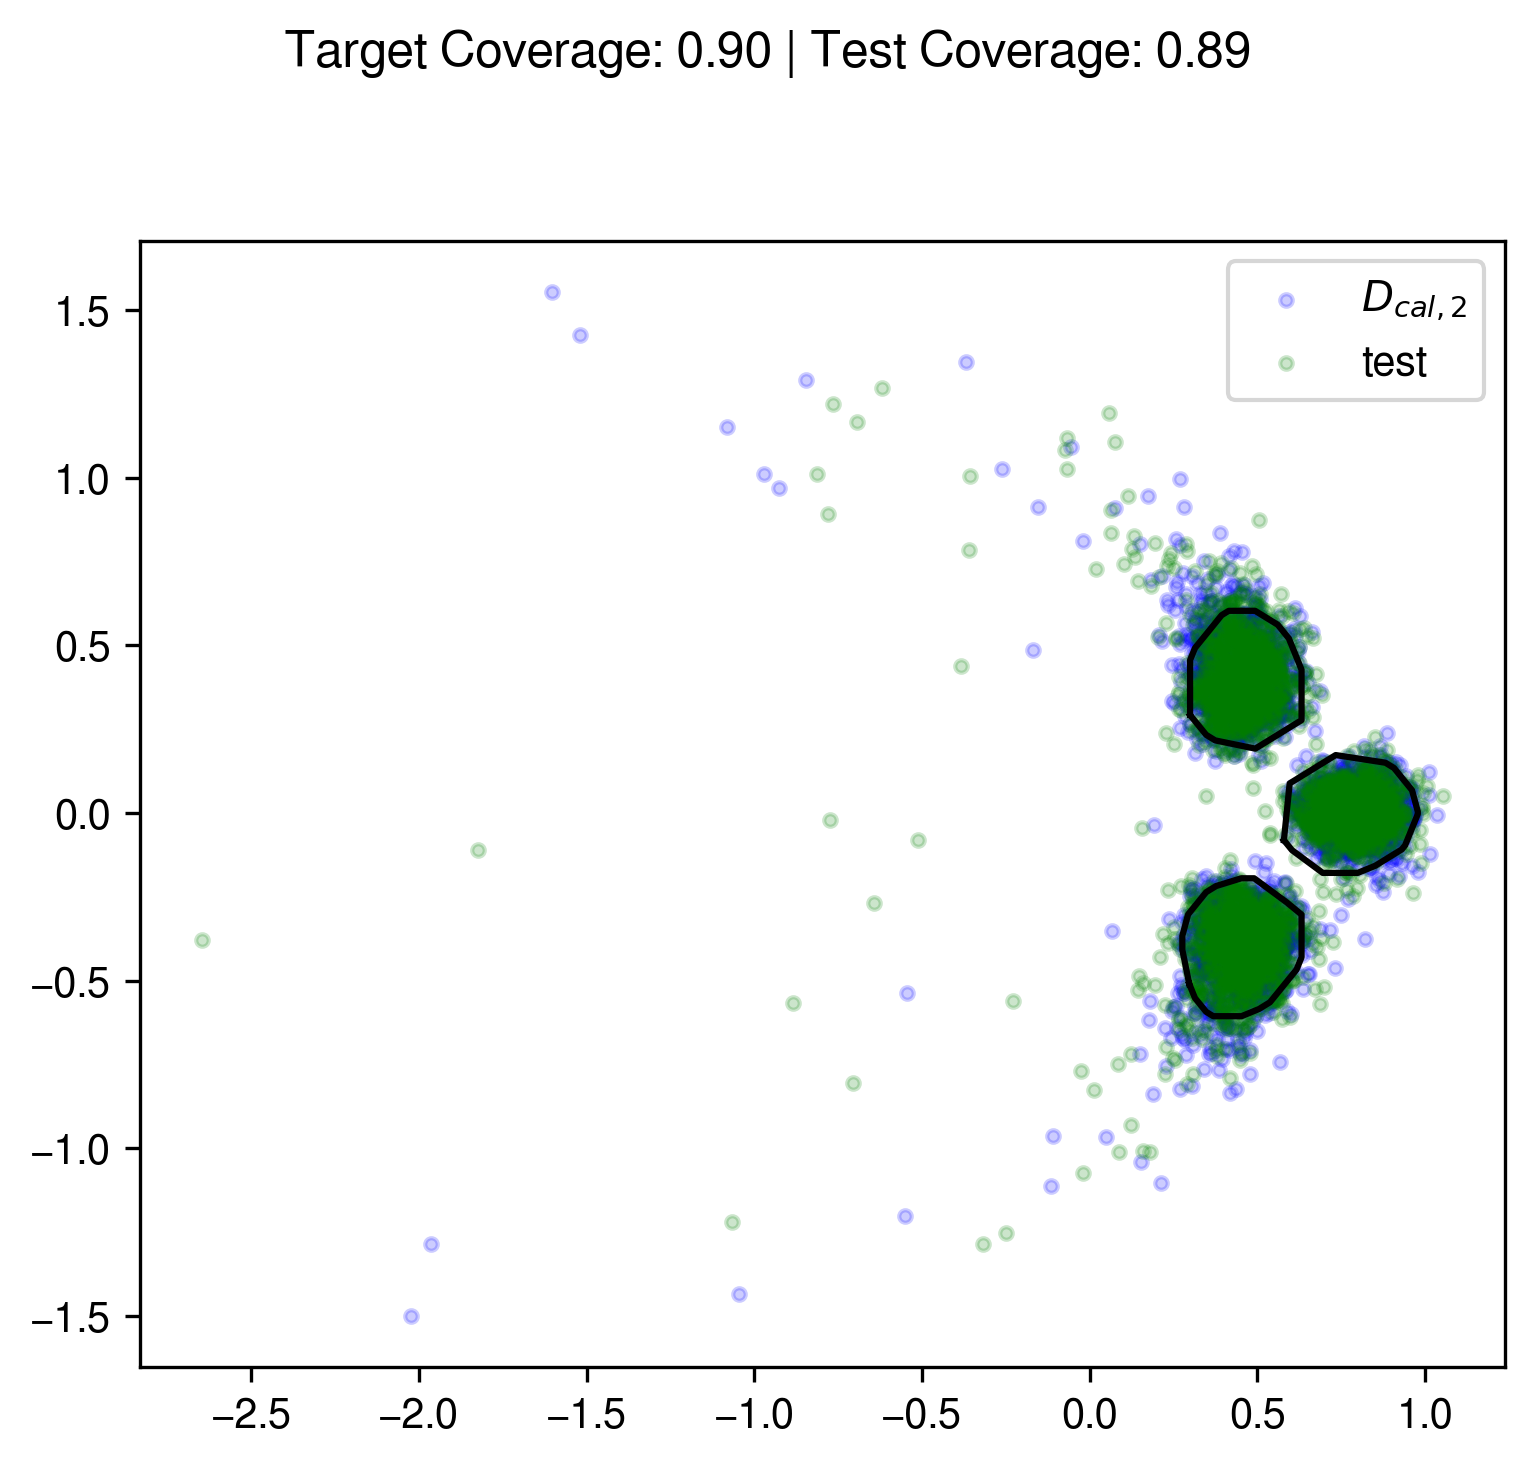

In [12]:
scores = pcr.calculate_scores(Z_test)
coverage = np.sum(scores < 0) / len(scores)
print("Test Coverage: ", coverage)

fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 5), dpi=300)
#ax.scatter(Z_cal_one[:, 0], Z_cal_one[:, 1], color="red", marker=".", label="$D_{cal,1}$")
ax.scatter(Z_cal_two[:, 0], Z_cal_two[:, 1], color="blue", marker=".", label="$D_{cal,2}$", alpha=0.2)
ax.scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="test", alpha=0.2)
ax.set_aspect("equal")
for shape_template in pcr.shapes:
    shape_template.plot(ax)
ax.legend()
fig.suptitle(f'Target Coverage: {DELTA:.2f} | Test Coverage: {coverage:.2f}')


Text(0.5, 0.98, 'Convex Hull Prediction Region for Endpoint')

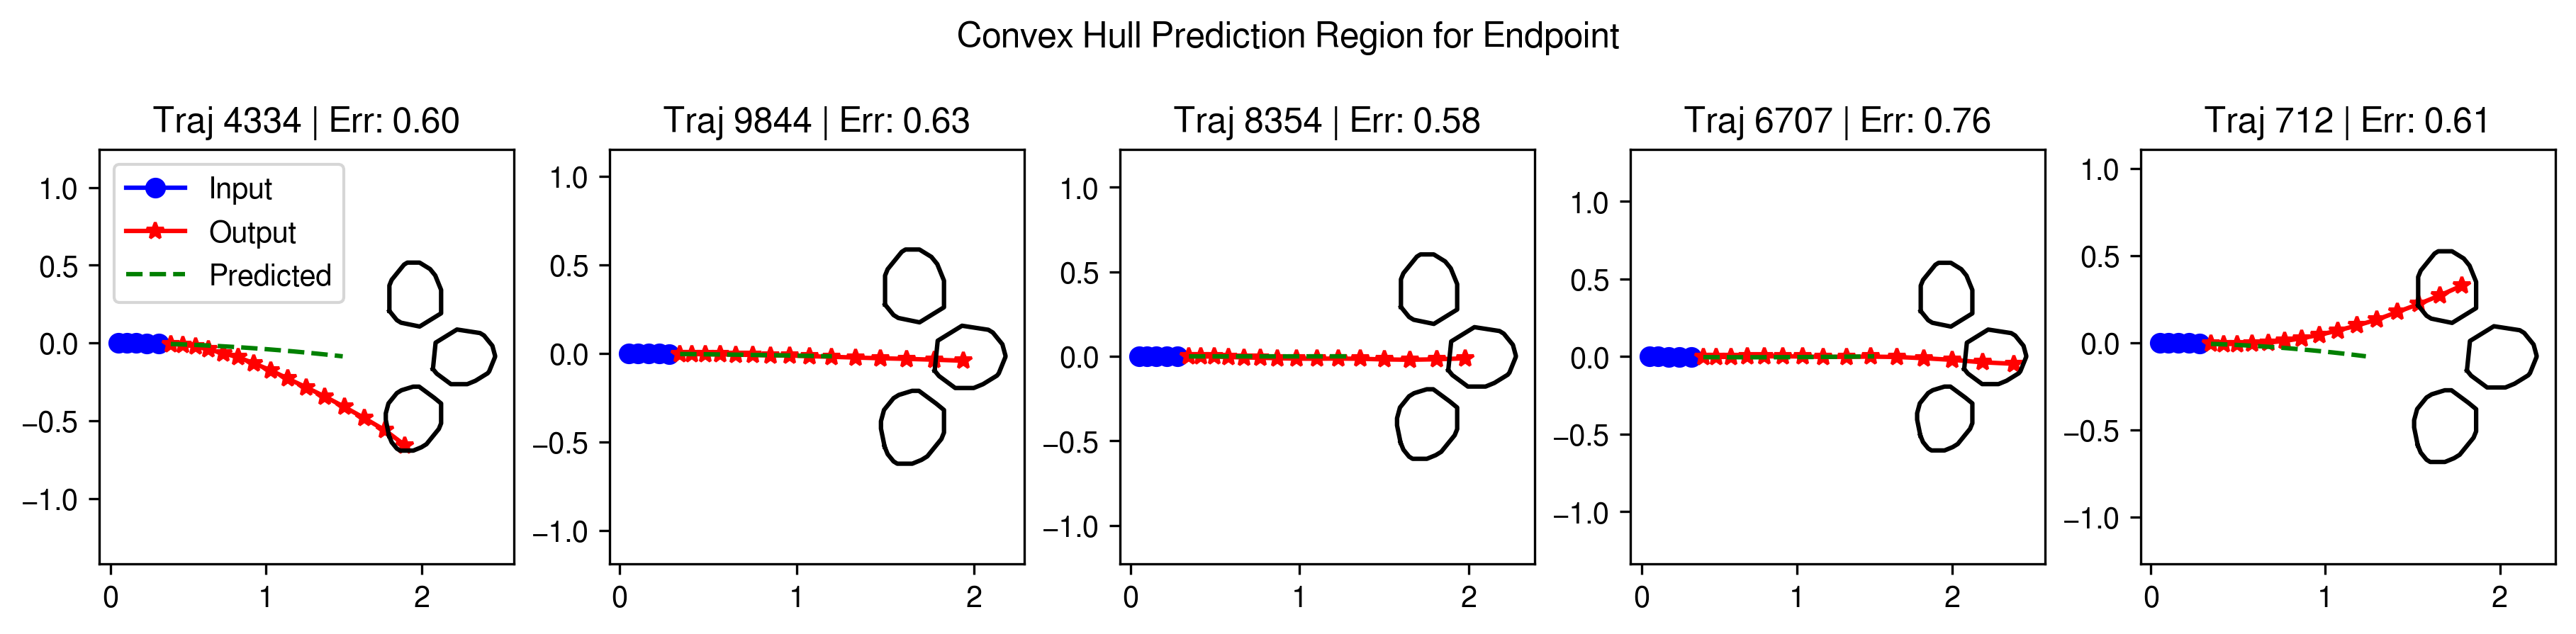

In [13]:
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    prediction = predictor.predict_trajectory(env_X[INDEX[i]])
    ax.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'bo-', label='Input')
    ax.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r*-', label='Output')
    error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--', label='Predicted')
    for shape_template in pcr.shapes:
        shape_template.plot(ax, offset_coords=prediction[-1])
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
fig.suptitle('Convex Hull Prediction Region for Endpoint')

  0%|          | 0/1000 [00:00<?, ?it/s]

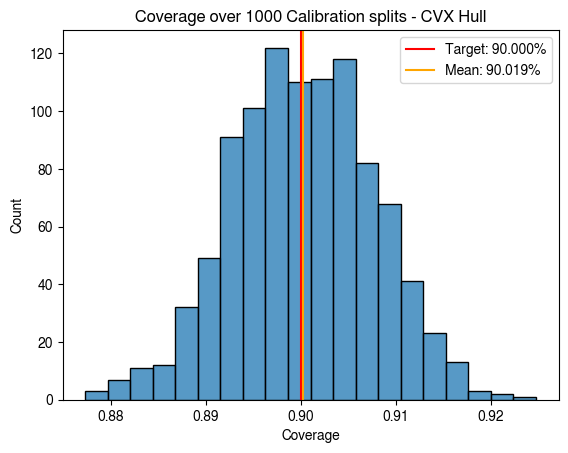

In [14]:
coverages = shuffle_split_testing(pcr, Z_eval, 1000, 0.5, 42)
sns.histplot(coverages, bins=20)
plt.axvline(x=DELTA, color="red", label=f"Target: {DELTA:.3%}")
plt.axvline(x=np.mean(coverages), color="orange", label=f"Mean: {np.mean(coverages):.3%}")
plt.title("Coverage over 1000 Calibration splits - CVX Hull")
plt.xlabel("Coverage")
plt.ylabel("Count")
plt.legend()

## Ellipsoid

In [15]:
de = KDE()
cl = MeanShiftClustering()
pcr = ConformalRegion(de, cl, Ellipse, DELTA)
pcr.fit(Z_cal_one)
pcr.conformalize(Z_cal_two)
print(pcr.normalizing_constant)

Total Weight Sum: 0.9769710809224834
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=756006, Wed Nov 22 23:24:25 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 5.482906965508254e-01 1.0e+00 9.82e-01  9e-01  1e+00 0:00.0
    2     18 7.321825017829777e-01 1.3e+00 9.64e-01  9e-01  1e+00 0:00.0
    3     27 9.090681583182979e-01 1.4e+00 9.65e-01  9e-01  1e+00 0:00.1
  100    900 6.945251549670629e-02 1.3e+02 1.92e-03  1e-04  2e-03 0:01.8
  200   1800 6.943829750009317e-02 4.4e+03 2.18e-05  5e-07  3e-05 0:03.6
  300   2700 6.943827945259864e-02 3.8e+04 1.30e-07  3e-10  2e-07 0:05.3
  323   2907 6.943827944948835e-02 7.6e+04 4.15e-08  7e-11  5e-08 0:05.7
termination on tolfun=1e-11 (Wed Nov 22 23:24:31 2023)
final/bestever f-value = 6.943828e-02 6.943828e-02 after 2908/2888 evaluations
incumbent solution: [-0.9785800176013969, 0.29045660020496583, 0.25228197729778357, 1.0730057666820656, 0.7680495798475089, -0.006574071750814613]
std devia

Test Coverage:  0.8986202759448111


Text(0.5, 0.98, 'Target Coverage: 0.90 | Test Coverage: 0.90')

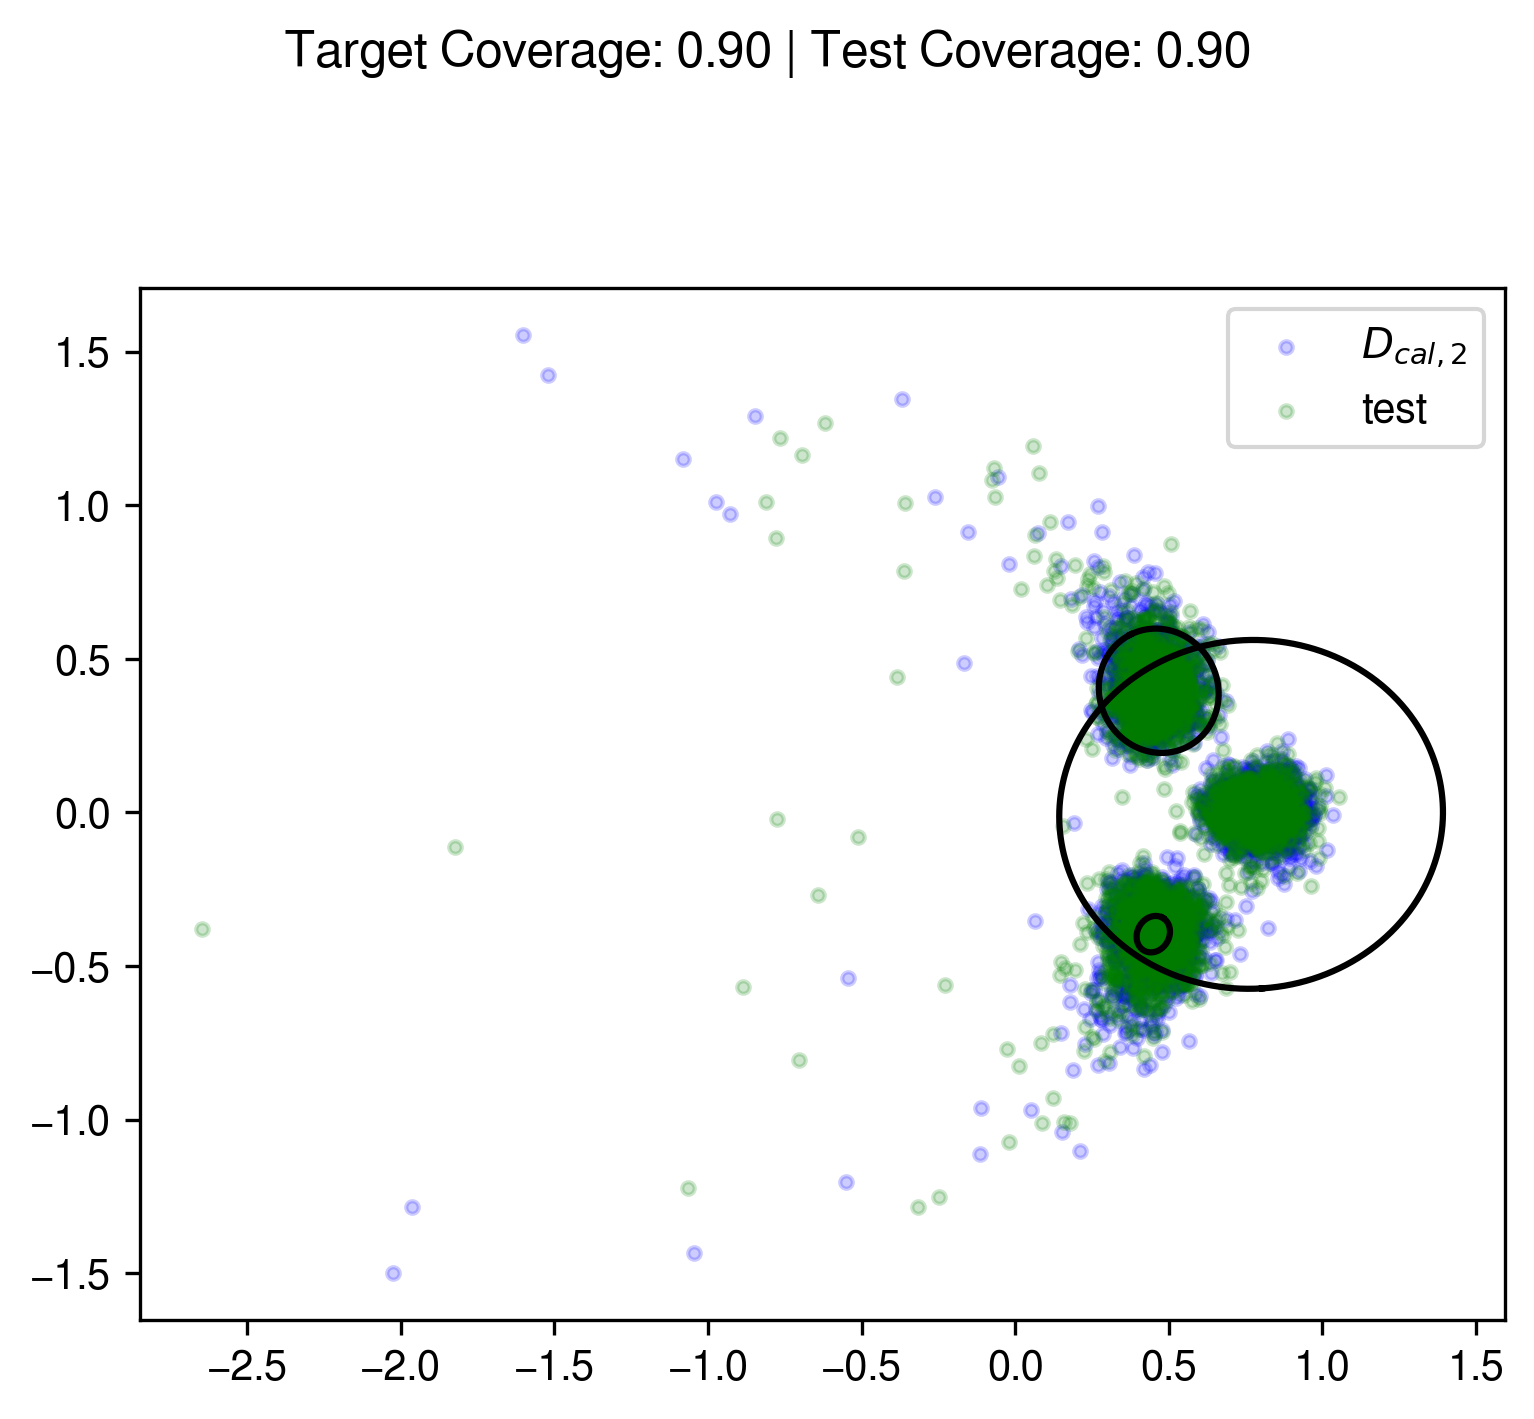

In [16]:
scores = pcr.calculate_scores(Z_test)
coverage = np.sum(scores < 0) / len(scores)
print("Test Coverage: ", coverage)

fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 5), dpi=300)
#ax.scatter(Z_cal_one[:, 0], Z_cal_one[:, 1], color="red", marker=".", label="$D_{cal,1}$")
ax.scatter(Z_cal_two[:, 0], Z_cal_two[:, 1], color="blue", marker=".", label="$D_{cal,2}$", alpha=0.2)
ax.scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="test", alpha=0.2)
ax.set_aspect("equal")
for shape_template in pcr.shapes:
    shape_template.plot(ax)
ax.legend()
fig.suptitle(f'Target Coverage: {DELTA:.2f} | Test Coverage: {coverage:.2f}')


Text(0.5, 0.98, 'Ellipsoid Prediction Region for Endpoint')

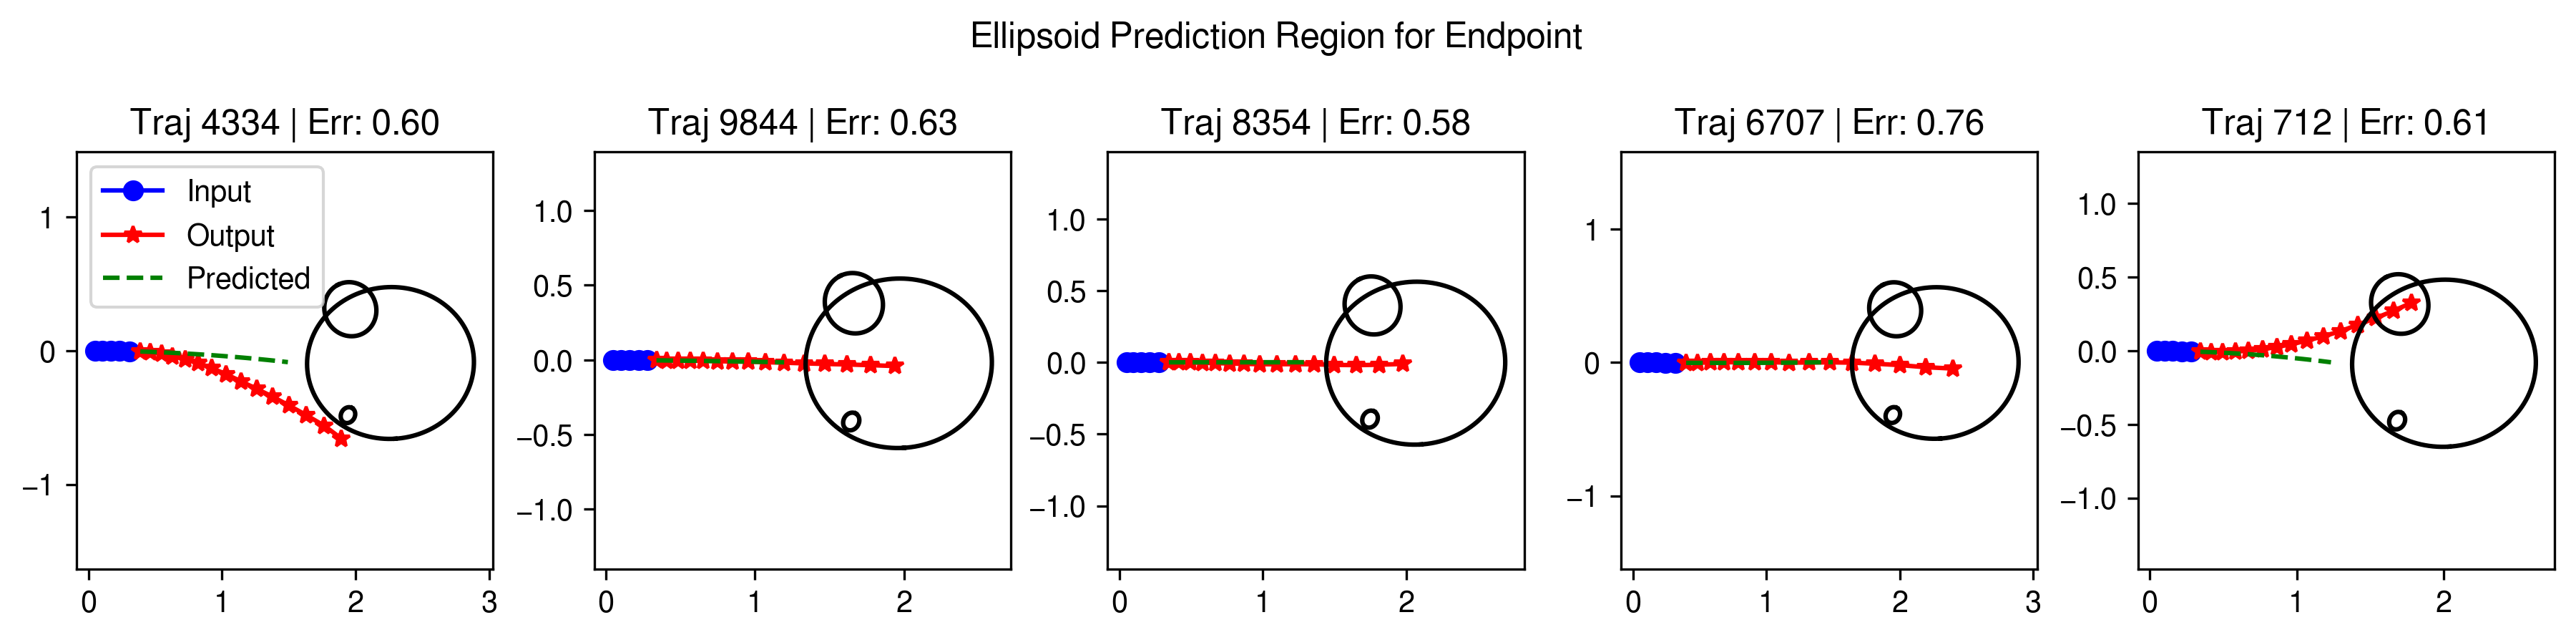

In [17]:
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    prediction = predictor.predict_trajectory(env_X[INDEX[i]])
    ax.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'bo-', label='Input')
    ax.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r*-', label='Output')
    error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--', label='Predicted')
    for shape_template in pcr.shapes:
        shape_template.plot(ax, offset_coords=prediction[-1])
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
fig.suptitle('Ellipsoid Prediction Region for Endpoint')

  0%|          | 0/1000 [00:00<?, ?it/s]

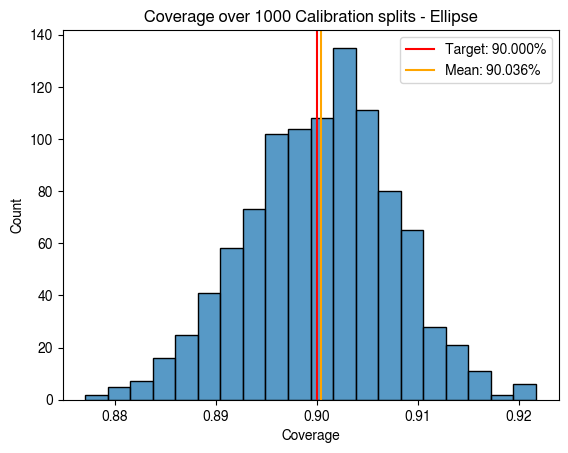

In [18]:
coverages = shuffle_split_testing(pcr, Z_eval, 1000, 0.5, 42)
sns.histplot(coverages, bins=20)
plt.axvline(x=DELTA, color="red", label=f"Target: {DELTA:.3%}")
plt.axvline(x=np.mean(coverages), color="orange", label=f"Mean: {np.mean(coverages):.3%}")
plt.title("Coverage over 1000 Calibration splits - Ellipse")
plt.xlabel("Coverage")
plt.ylabel("Count")
plt.legend()

## Hyperrectangle

In [19]:
de = KDE()
cl = MeanShiftClustering()
pcr = ConformalRegion(de, cl, HyperRectangle, DELTA)
pcr.fit(Z_cal_one)
pcr.conformalize(Z_cal_two)

Total Weight Sum: 0.9769710809224834


Test Coverage:  0.8986202759448111


Text(0.5, 0.98, 'Target Coverage: 0.90 | Test Coverage: 0.90')

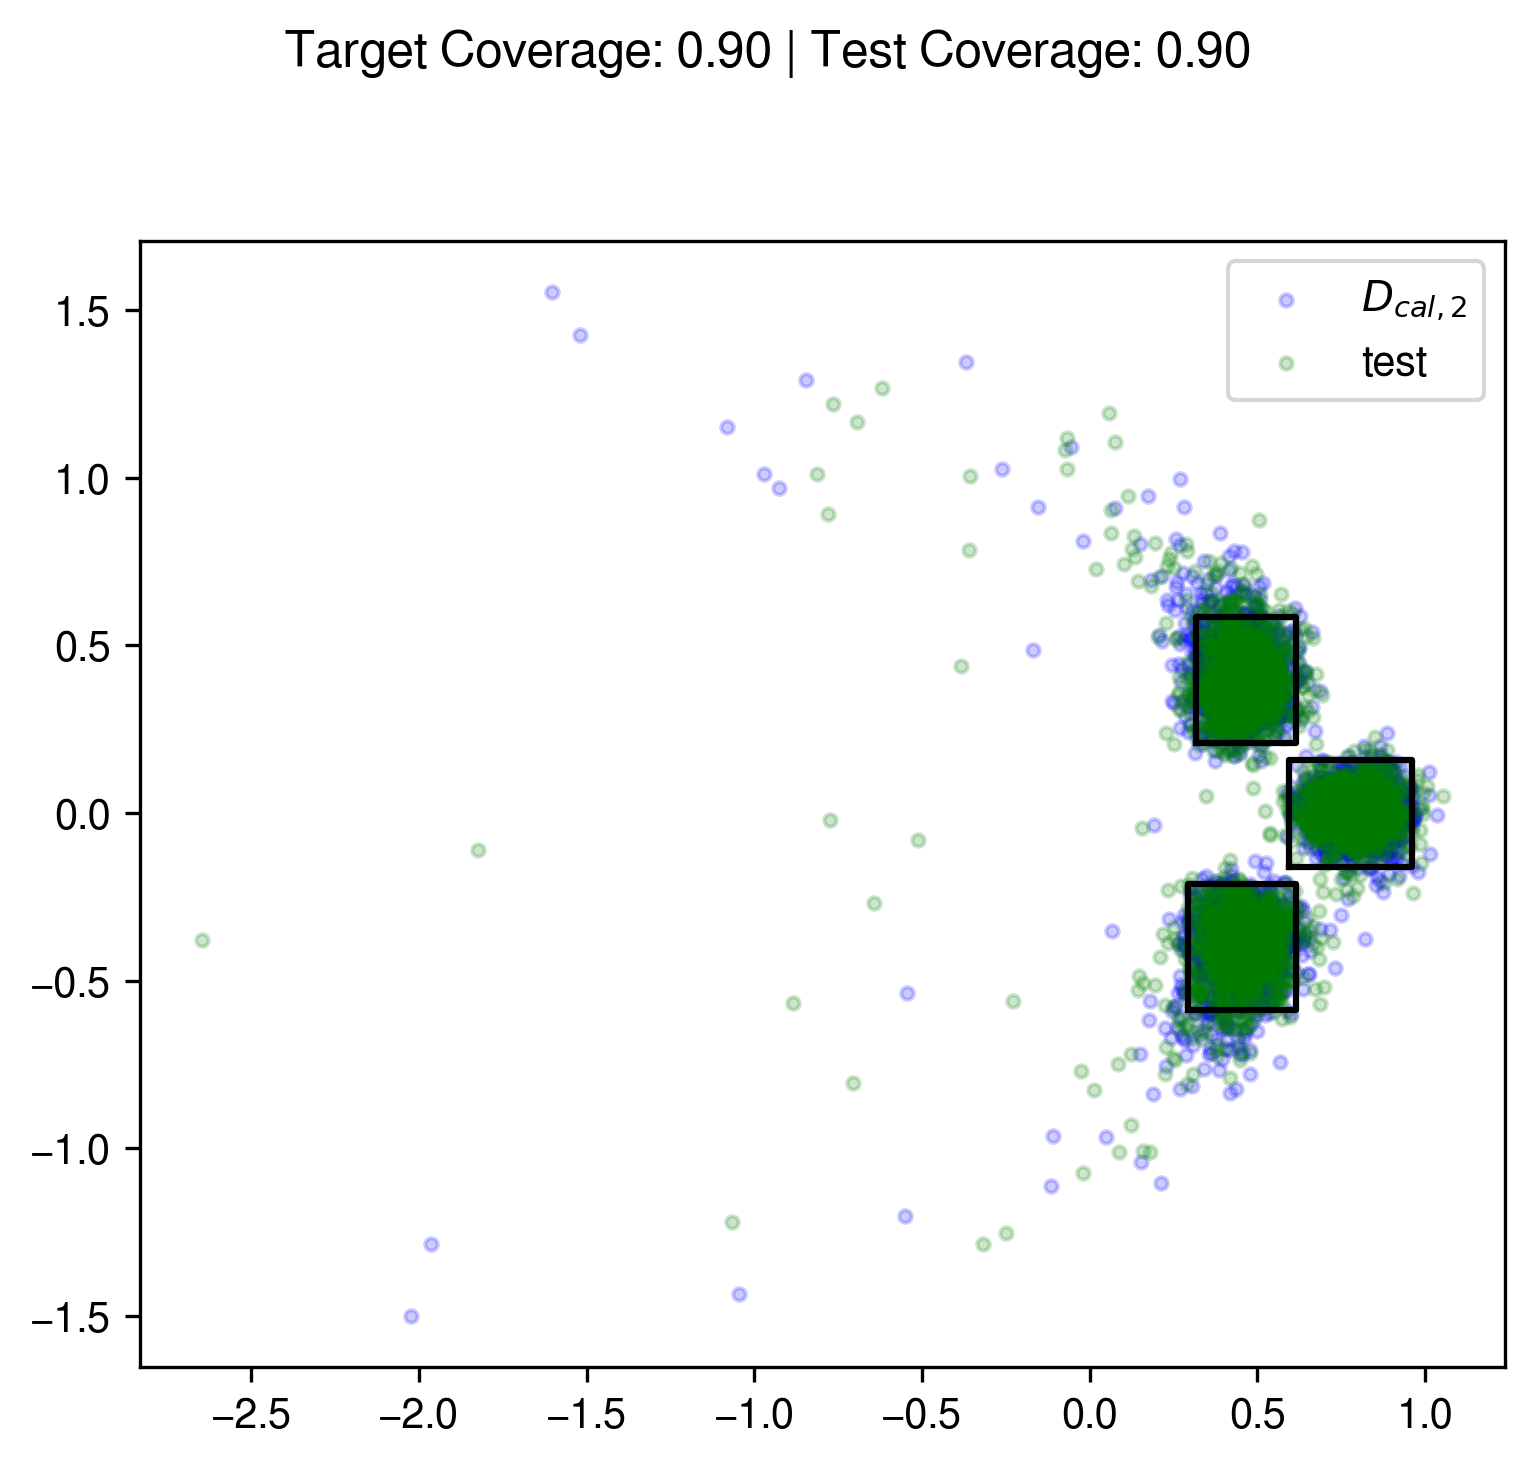

In [20]:
scores = pcr.calculate_scores(Z_test)
coverage = np.sum(scores < 0) / len(scores)
print("Test Coverage: ", coverage)

fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 5), dpi=300)
#ax.scatter(Z_cal_one[:, 0], Z_cal_one[:, 1], color="red", marker=".", label="$D_{cal,1}$")
ax.scatter(Z_cal_two[:, 0], Z_cal_two[:, 1], color="blue", marker=".", label="$D_{cal,2}$", alpha=0.2)
ax.scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="test", alpha=0.2)
ax.set_aspect("equal")
for shape_template in pcr.shapes:
    shape_template.plot(ax)
ax.legend()
fig.suptitle(f'Target Coverage: {DELTA:.2f} | Test Coverage: {coverage:.2f}')


Text(0.5, 0.98, 'Hyperrectangle Prediction Region for Endpoint')

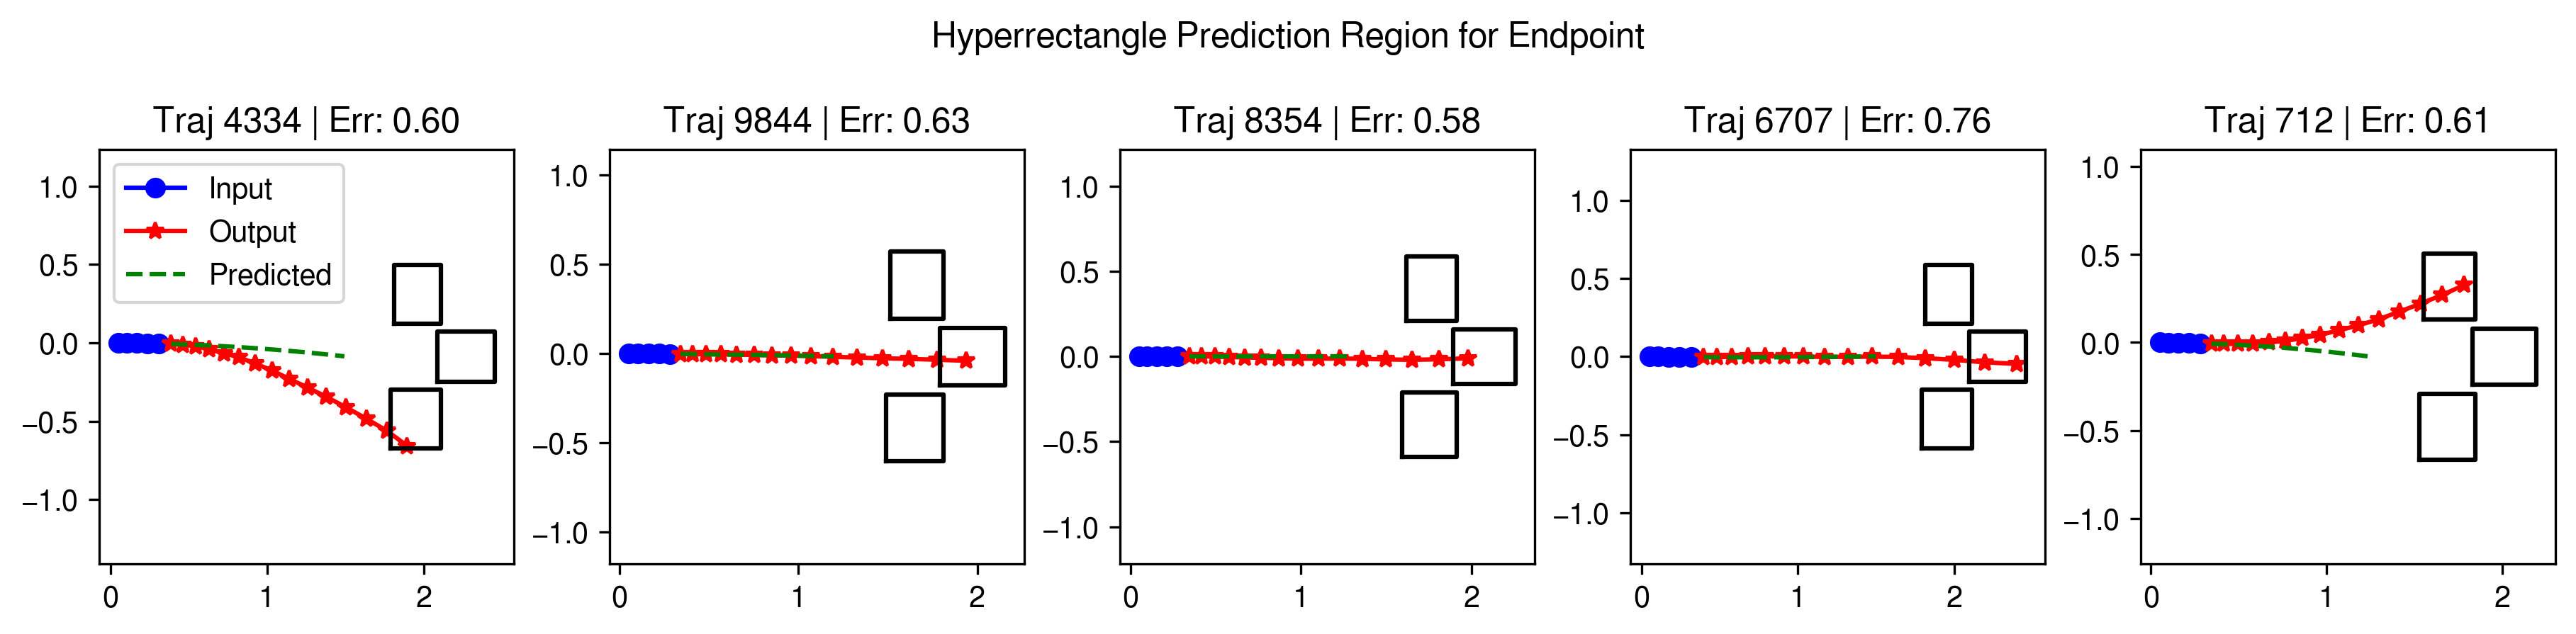

In [21]:
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    prediction = predictor.predict_trajectory(env_X[INDEX[i]])
    ax.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'bo-', label='Input')
    ax.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r*-', label='Output')
    error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--', label='Predicted')
    for shape_template in pcr.shapes:
        shape_template.plot(ax, offset_coords=prediction[-1])
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
fig.suptitle('Hyperrectangle Prediction Region for Endpoint')

  0%|          | 0/1000 [00:00<?, ?it/s]

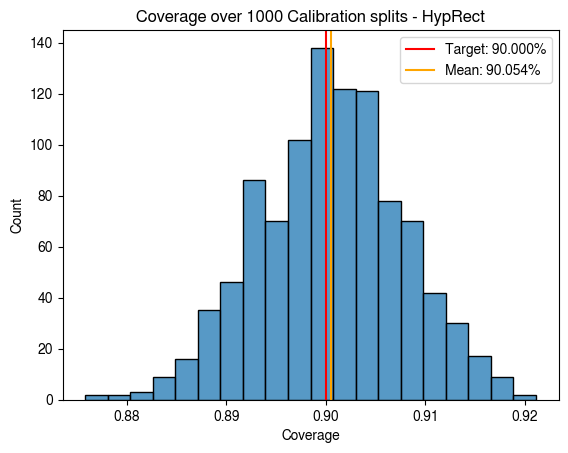

In [22]:
coverages = shuffle_split_testing(pcr, Z_eval, 1000, 0.5, 42)
sns.histplot(coverages, bins=20)
plt.axvline(x=DELTA, color="red", label=f"Target: {DELTA:.3%}")
plt.axvline(x=np.mean(coverages), color="orange", label=f"Mean: {np.mean(coverages):.3%}")
plt.title("Coverage over 1000 Calibration splits - HypRect")
plt.xlabel("Coverage")
plt.ylabel("Count")
plt.legend()